<a href="https://colab.research.google.com/github/hidhartha/Topic_modelling_of_amazon_reviews/blob/main/Topic_modelling_Amazon_earphone_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modelling of Earphone Reviews in Amazon.
Dataset used: Amazon Earphone Reviews(from Kaggle)

Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import re,random,os
import seaborn as sns
from nltk.corpus import stopwords
import string
from pprint import pprint as pprint

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Topic modelling amazon earphone reviews/AllProductReviews.csv')

In [4]:
df

,ReviewTitle,ReviewBody,ReviewStar,Product
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255
4,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255
...,...,...,...,...
14332,Good\n,Good\n,4,JBL T110BT
14333,Amazing Product\n,An amazing product but a bit costly.\n,5,JBL T110BT
14334,Not bad\n,Sound\n,1,JBL T110BT
14335,a good product\n,the sound is good battery life is good but the...,5,JBL T110BT


In [5]:
df.groupby('Product').count()

,ReviewTitle,ReviewBody,ReviewStar
Product,,,
Flybot Beat,23,23,23
Flybot Boom,82,82,82
Flybot Wave,182,182,182
JBL T110BT,1922,1922,1922
JBL T205BT,1411,1411,1411
PTron Intunes,254,254,254
Samsung EO-BG950CBEIN,224,224,224
Sennheiser CX 6.0BT,5000,5000,5000
Skullcandy S2PGHW-174,239,239,239


In [6]:
df.rename(columns = {'ReviewBody':'review'}, inplace = True)

Dropping columns 'ReviewTitle' and 'ReviewStar' as they are not required for analysis.

In [7]:
df = df.drop(['ReviewTitle', 'ReviewStar'], axis =1)

In [8]:
df[500:600]

,review,Product
500,Awesome !!!Go for itThe angle of ear tip makes...,boAt Rockerz 255
501,Sound Quality: Insane bassBattery life: a bit ...,boAt Rockerz 255
502,Absolute Rock Star! No problem in paring with ...,boAt Rockerz 255
503,Overall its a good deal in the price given. I ...,boAt Rockerz 255
504,I am using this for last two months. Over all ...,boAt Rockerz 255
...,...,...
595,The product looked fine when I opened it. But ...,boAt Rockerz 255
596,Sometimes there is connectivity issue. I have ...,boAt Rockerz 255
597,Using this for he past two months- the sound i...,boAt Rockerz 255
598,GOOD PRODUCT. APROX. 6 HOUR BATTERY LIFE ON FU...,boAt Rockerz 255


## Considering boAt Rockerz 255 Product
*I am performing topic modelling of reviews of only one product(boat Rockerz 255 Product). They are total 5000 reviews of this product.*

In [9]:
df = df[df['Product']=="boAt Rockerz 255"]
df

,review,Product
0,No doubt it has a great bass and to a great ex...,boAt Rockerz 255
1,"This earphones are unreliable, i bought it be...",boAt Rockerz 255
2,"i bought itfor 999,I purchased it second time,...",boAt Rockerz 255
3,Its sound quality is adorable. overall it was ...,boAt Rockerz 255
4,Its Awesome... Good sound quality & 8-9 hrs ba...,boAt Rockerz 255
...,...,...
4995,Sound quality is superb..Battery life is good....,boAt Rockerz 255
4996,Nice earphone........ Good bt connectivity. An...,boAt Rockerz 255
4997,Stopped working.... Sound is breaking. Pls gui...,boAt Rockerz 255
4998,Awesome product... worth the price and the sou...,boAt Rockerz 255


## Plotting Tools

In [13]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=45c439cbf1a9a539394dd5051a9bd48741645e0d46c6c5945855ed88c2f45733
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [14]:
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## Tokenization

In [15]:
def sent_to_words(sentences, deacc=True): 
    for sentence in sentences:
        yield(simple_preprocess(str(sentence)))

data=df['review'].values.tolist()
data_words=list(sent_to_words(data))

In [16]:
print(data_words[:2])

[['no', 'doubt', 'it', 'has', 'great', 'bass', 'and', 'to', 'great', 'extent', 'noise', 'cancellation', 'and', 'decent', 'sound', 'clarity', 'and', 'mindblowing', 'battery', 'but', 'the', 'following', 'dissapointed', 'me', 'though', 'tried', 'lot', 'to', 'adjust', 'bluetooth', 'range', 'not', 'more', 'than', 'pain', 'in', 'ear', 'due', 'the', 'conical', 'buds', 'can', 'be', 'removed', 'wires', 'are', 'bit', 'long', 'which', 'makes', 'it', 'odd', 'in', 'front', 'no', 'pouch', 'provided', 'worst', 'part', 'is', 'very', 'low', 'quality', 'and', 'distoring', 'mic', 'other', 'person', 'keeps', 'complaining', 'about', 'my', 'voice'], ['this', 'earphones', 'are', 'unreliable', 'bought', 'it', 'before', 'days', 'meanwhile', 'right', 'side', 'ear', 'buds', 'got', 'cracked', 'automatically', 'and', 'it', 'got', 'divided', 'in', 'two', 'parts', 'and', 'sound', 'quality', 'is', 'also', 'not', 'that', 'much', 'good', 'but', 'ok', 'one', 'more', 'thing', 'bass', 'is', 'not', 'good', 'as', 'it', 'is'

## Removing Stopwords

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
from nltk.corpus import stopwords
stop_words= stopwords.words('english') + list(string.punctuation)

In [19]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_npstops= remove_stopwords(data_words)

## Lemmatization

In [20]:
def lemmatization(texts,allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """https://spacy.io/api/annotation"""
    texts_out=[]
    for sent in texts:
        doc=nlp(' '.join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
nlp = spacy.load("en_core_web_sm")

In [22]:
data_lemmatized=lemmatization(data_words_npstops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [23]:
print(' '.join(data_lemmatized[3]))

sound quality adorable overall good week stop work never power claim warrenty still undergo


In [24]:
print(data_lemmatized[:4])

[['doubt', 'great', 'bass', 'great', 'extent', 'noise', 'cancellation', 'decent', 'sound', 'clarity', 'mindblowing', 'battery', 'follow', 'dissapointe', 'try', 'lot', 'adjust', 'bluetooth', 'range', 'pain', 'ear', 'due', 'conical', 'bud', 'remove', 'wire', 'bite', 'long', 'make', 'odd', 'front', 'pouch', 'provide', 'bad', 'part', 'low', 'quality', 'distore', 'mic', 'person', 'keep', 'complain', 'voice'], ['unreliable', 'buy', 'day', 'meanwhile', 'right', 'side', 'ear', 'bud', 'crack', 'automatically', 'divide', 'part', 'sound', 'quality', 'also', 'much', 'good', 'thing', 'bass', 'good', 'boat', 'earphone', 'guy', 'also', 'proof', 'attach', 'picsplease', 'see', 'think', 'buy', 'unreliable', 'product', 'thank'], ['buy', 'purchase', 'second', 'time', 'gift', 'first', 'brother', 'really', 'good', 'sound', 'quality', 'really', 'good', 'connect', 'device', 'connect', 'laptop', 'mobile', 'listen', 'muaic', 'lappy', 'get', 'call', 'switch', 'mobile', 'switch', 'device', 'good', 'price', 'aweso

## LDA

In [27]:
id2word=corpora.Dictionary(data_lemmatized)
corpus=[id2word.doc2bow(text) for text in data_lemmatized]
print(corpus[2])

[(3, 2), (16, 1), (35, 1), (38, 1), (46, 1), (51, 3), (65, 2), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1)]


## Building Base LDA Model

In [29]:
lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [30]:
lda_model.print_topics()

[(0,
  '0.035*"call" + 0.032*"connectivity" + 0.026*"music" + 0.025*"voice" + 0.023*"phone" + 0.016*"mic" + 0.016*"audio" + 0.013*"hear" + 0.013*"break" + 0.010*"mobile"'),
 (1,
  '0.058*"work" + 0.046*"product" + 0.041*"month" + 0.031*"bad" + 0.024*"use" + 0.022*"stop" + 0.020*"side" + 0.020*"buy" + 0.016*"day" + 0.016*"charge"'),
 (2,
  '0.117*"good" + 0.082*"sound" + 0.069*"quality" + 0.047*"product" + 0.038*"battery" + 0.023*"price" + 0.023*"bass" + 0.022*"nice" + 0.020*"life" + 0.017*"awesome"')]

In [31]:
doc_lda=lda_model[corpus]

In [32]:
print(lda_model[corpus][0])

([(0, 0.36522743), (1, 0.06498102), (2, 0.56979156)], [(0, [0]), (1, [1]), (2, [2]), (3, [2]), (4, [2, 0, 1]), (5, [2, 0]), (6, [2, 1]), (7, [2]), (8, [2]), (9, [0]), (10, [0, 2, 1]), (11, [2]), (12, [0, 2]), (13, [0, 2, 1]), (14, [2, 0]), (15, [0]), (16, [2]), (17, [2, 0]), (18, [0, 2, 1]), (19, [0, 2]), (20, [2]), (21, [0, 2]), (22, [2]), (23, [0]), (24, [2, 0]), (25, [0, 2]), (26, [0]), (27, [0, 2, 1]), (28, [2, 0]), (29, [2, 0, 1]), (30, [2]), (31, [2, 0]), (32, [0]), (33, [2, 0]), (34, [2]), (35, [2]), (36, [2]), (37, [0, 2]), (38, [2]), (39, [1, 0, 2]), (40, [0]), (41, [2])], [(0, [(0, 0.9975869)]), (1, [(1, 0.995708)]), (2, [(2, 0.9996365)]), (3, [(2, 0.9997813)]), (4, [(0, 0.2770451), (1, 0.019514177), (2, 0.7034407)]), (5, [(0, 0.24700229), (2, 0.7529183)]), (6, [(1, 0.13063693), (2, 0.86325544)]), (7, [(2, 0.9990288)]), (8, [(2, 0.9946417)]), (9, [(0, 0.9884656)]), (10, [(0, 0.82314855), (1, 0.030166276), (2, 0.14668514)]), (11, [(2, 0.9965779)]), (12, [(0, 0.9686451), (2, 0.

## Performance Check

In [33]:
print("Perplexity: ",lda_model.log_perplexity(corpus))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

Perplexity:  -6.363769581425233


In [34]:
from gensim.models import CoherenceModel
coherence_model_lda=CoherenceModel(model=lda_model,texts=data_lemmatized,dictionary=id2word,coherence='c_v')

coherence_lda=coherence_model_lda.get_coherence()
print('Coherence Score: ',coherence_lda)

Coherence Score:  0.5880324410132997


# Finding Optimum Coherence

In [35]:
def compute_coherence_values(dictionary,corpus,texts,start,limit,step):
    coherence_vals=[]
    model_list=[]
    
    for num_topics in range(start,limit,step):        
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,
                                              num_topics=num_topics,random_state=100,
                                              chunksize=100,passes=10,alpha='auto',per_word_topics=True)

        model_list.append(model)
        
        coherencemodel=CoherenceModel(model=model,texts=texts,dictionary=dictionary,coherence='c_v')
        
        coherence_vals.append(coherencemodel.get_coherence())
    return model_list,coherence_vals

model_list,coherence_vals=compute_coherence_values(dictionary=id2word,
                                                   corpus=corpus,texts=data_lemmatized,
                                                   start=2,limit=10,step=1)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

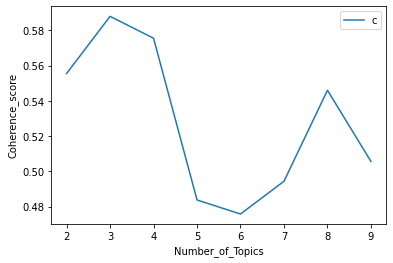

In [36]:
limit=10
start=2
step=1
x=range(start,limit,step)

plt.plot(x,coherence_vals)
plt.xlabel('Number_of_Topics')
plt.ylabel('Coherence_score')
plt.legend(('coh'),loc='best')
plt.show()

In [37]:
for m, cv in zip(x,coherence_vals):
    print("Number of topics = ",m,'has coherence value of :',round(cv,4))

Number of topics =  2 has coherence value of : 0.5555
Number of topics =  3 has coherence value of : 0.588
Number of topics =  4 has coherence value of : 0.5756
Number of topics =  5 has coherence value of : 0.4837
Number of topics =  6 has coherence value of : 0.4758
Number of topics =  7 has coherence value of : 0.4944
Number of topics =  8 has coherence value of : 0.5461
Number of topics =  9 has coherence value of : 0.5056


**So we are getting Highest coherence score for num topics = 3**. Higher the coherence score we will get more clear and distinct topics.So, I am taking **number of topics = 3**.

In [38]:
optimal_model=model_list[1] 
model_topics=optimal_model.show_topics(formatted=False)

pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.035*"call" + 0.032*"connectivity" + 0.026*"music" + 0.025*"voice" + '
  '0.023*"phone" + 0.016*"mic" + 0.016*"audio" + 0.013*"hear" + 0.013*"break" '
  '+ 0.010*"mobile"'),
 (1,
  '0.058*"work" + 0.046*"product" + 0.041*"month" + 0.031*"bad" + 0.024*"use" '
  '+ 0.022*"stop" + 0.020*"side" + 0.020*"buy" + 0.016*"day" + 0.016*"charge"'),
 (2,
  '0.117*"good" + 0.082*"sound" + 0.069*"quality" + 0.047*"product" + '
  '0.038*"battery" + 0.023*"price" + 0.023*"bass" + 0.022*"nice" + '
  '0.020*"life" + 0.017*"awesome"')]


In [39]:
model_topics=optimal_model.show_topics(formatted=False)  
print(model_topics)

[(0, [('call', 0.03502455), ('connectivity', 0.032102518), ('music', 0.026265511), ('voice', 0.024778893), ('phone', 0.023309853), ('mic', 0.016238848), ('audio', 0.016143478), ('hear', 0.013247192), ('break', 0.013076544), ('mobile', 0.0104722055)]), (1, [('work', 0.057573643), ('product', 0.046280358), ('month', 0.04119816), ('bad', 0.03067983), ('use', 0.023570633), ('stop', 0.022442797), ('side', 0.02028987), ('buy', 0.020159515), ('day', 0.016259337), ('charge', 0.015808765)]), (2, [('good', 0.117470406), ('sound', 0.08174157), ('quality', 0.0687274), ('product', 0.04657666), ('battery', 0.037551895), ('price', 0.023020277), ('bass', 0.022590682), ('nice', 0.021939466), ('life', 0.020281654), ('awesome', 0.016903048)])]


## Visualizing the Topics

In [41]:
pyLDAvis.enable_notebook()
vis1=pyLDAvis.gensim_models.prepare(optimal_model,corpus,id2word)
vis1

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.283024  0.078511       1        1  58.070293
1     -0.060030 -0.243785       2        1  28.307189
0     -0.222993  0.165274       3        1  13.622518, topic_info=        Term         Freq        Total Category  logprob  loglift
51      good  4297.000000  4297.000000  Default  30.0000  30.0000
38     sound  2990.000000  2990.000000  Default  29.0000  29.0000
35   quality  2514.000000  2514.000000  Default  28.0000  28.0000
102     work  1027.000000  1027.000000  Default  27.0000  27.0000
150    month   735.000000   735.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
135    issue    71.984013   138.052609   Topic3  -4.7806   1.3423
90      time    82.388230   286.362635   Topic3  -4.6456   0.7476
239  problem    57.598883   165.638565   Topic3  -5.0035   0.9371
25      make    44.318428    72.781811   Topic3  -5.2656   1.4974
28     noise    51.950668   433.296147   Topic3  -5.1067  -0.1277

[150 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
414       1  0.012329     able
414       2  0.012329     able
414       3  0.986294     able
42        1  0.989721     also
42        2  0.008581     also
...     ...       ...      ...
353       2  0.985741  working
353       3  0.012021  working
144       1  0.995595    worth
144       2  0.002354    worth
144       3  0.002354    worth

[336 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

So, I obtained the highest coherence value with number of topic equal to 3. We can identify 3 distinct topics in the reviews. 
 

*   Topic 1 is related to sound quality, bass, battery, price.
*   Topic 2 is related to product, use, working, warranty etc. 
*   Topic 3 is related to call, connecivity, mic, music, audio,voice etc.




 

**Now finding the dominant topic in each of the reviews**

In [42]:
reviews = df['review']

In [43]:
def func(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized, original_text = reviews):
 
    sent_topics_df = pd.DataFrame()   
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)      
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Most Dominant Topic', 'Percentage Contribution', 'Topic keywords']  
    contents = original_text
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [44]:
dom_topic_reviews_df = func(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized, original_text=reviews)

In [45]:
dom_topic_reviews_df.head(10)

,Most Dominant Topic,Percentage Contribution,Topic keywords,review
0,2.0,0.5698,"good, sound, quality, product, battery, price,...",No doubt it has a great bass and to a great ex...
1,2.0,0.5499,"good, sound, quality, product, battery, price,...","This earphones are unreliable, i bought it be..."
2,2.0,0.5157,"good, sound, quality, product, battery, price,...","i bought itfor 999,I purchased it second time,..."
3,1.0,0.6080,"work, product, month, bad, use, stop, side, bu...",Its sound quality is adorable. overall it was ...
4,2.0,0.5895,"good, sound, quality, product, battery, price,...",Its Awesome... Good sound quality & 8-9 hrs ba...
5,1.0,0.8647,"work, product, month, bad, use, stop, side, bu...","After 11 days, the charging port isn't working..."
6,2.0,0.7643,"good, sound, quality, product, battery, price,...",Sound-4.5/5Build quality-4.5/5Battery life -4/...
7,2.0,0.4615,"good, sound, quality, product, battery, price,...",After one month usage reviewing this .Pros-1- ...
8,2.0,0.5097,"good, sound, quality, product, battery, price,...",I can’t get enough of this earphone! The bass ...
9,1.0,0.7863,"work, product, month, bad, use, stop, side, bu...",The product durability is 1 month..I just lost...


So, in each of the reviews the most dominant topic is found out. This will help us to classify the reviews into different topics easily.